# Inference Tutorial
First, we have to import the dependencies needed and initialize the detector as well as the post-processing pipeline.

In [2]:
from PIL import Image
import numpy as np
import sys
sys.path.append('..')

import src.layoutparser.models.detectron2.layoutmodel as lp
import src.layoutparser.visualization as viz
import src.layoutparser.ocr.tesseract_agent as tes

from seg_post_process.post_segmentation import PostProcessingSegmentation

In [6]:
CONFIG_PATH        = '../3_class_model/config.yaml'
MODEL_PATH         = '../3_class_model/model_final.pth'
LABEL_MAP          = {1:"Paragraph", 2:"OtherText", 3:"Visual"}
ROI                = 1
PERCENT_THRESHOLD = 0.25
IMAGE_PATH         = '../data/demo/00000269.tif'

The model and its config file can be downloaded from https://drive.google.com/drive/folders/15KNAPItTzDQwu-t5clvVq3b_JmhEI7th?usp=sharing and should be put in the folder '3_class_model'

In [4]:
model = lp.Detectron2LayoutModel(
            config_path = CONFIG_PATH,
            model_path  = MODEL_PATH,
            label_map   = LABEL_MAP, 
            extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8] # Optional
        )
    
ocr_agent = tes.TesseractAgent(languages='eng') 

In [8]:
im = Image.open(IMAGE_PATH)

layout = model.detect(im)

masks = model.masks(im)

/home/georgi006/anaconda3/envs/layout/lib/python3.9/site-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/georgi006/anaconda3/envs/layout/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
post = PostProcessingSegmentation(layout, im, masks,{1:"Paragraph", 2:"OtherText", 3:"Visual"})

In [10]:
image, boxes = post.pipeline(ROI, PERCENT_THRESHOLD)

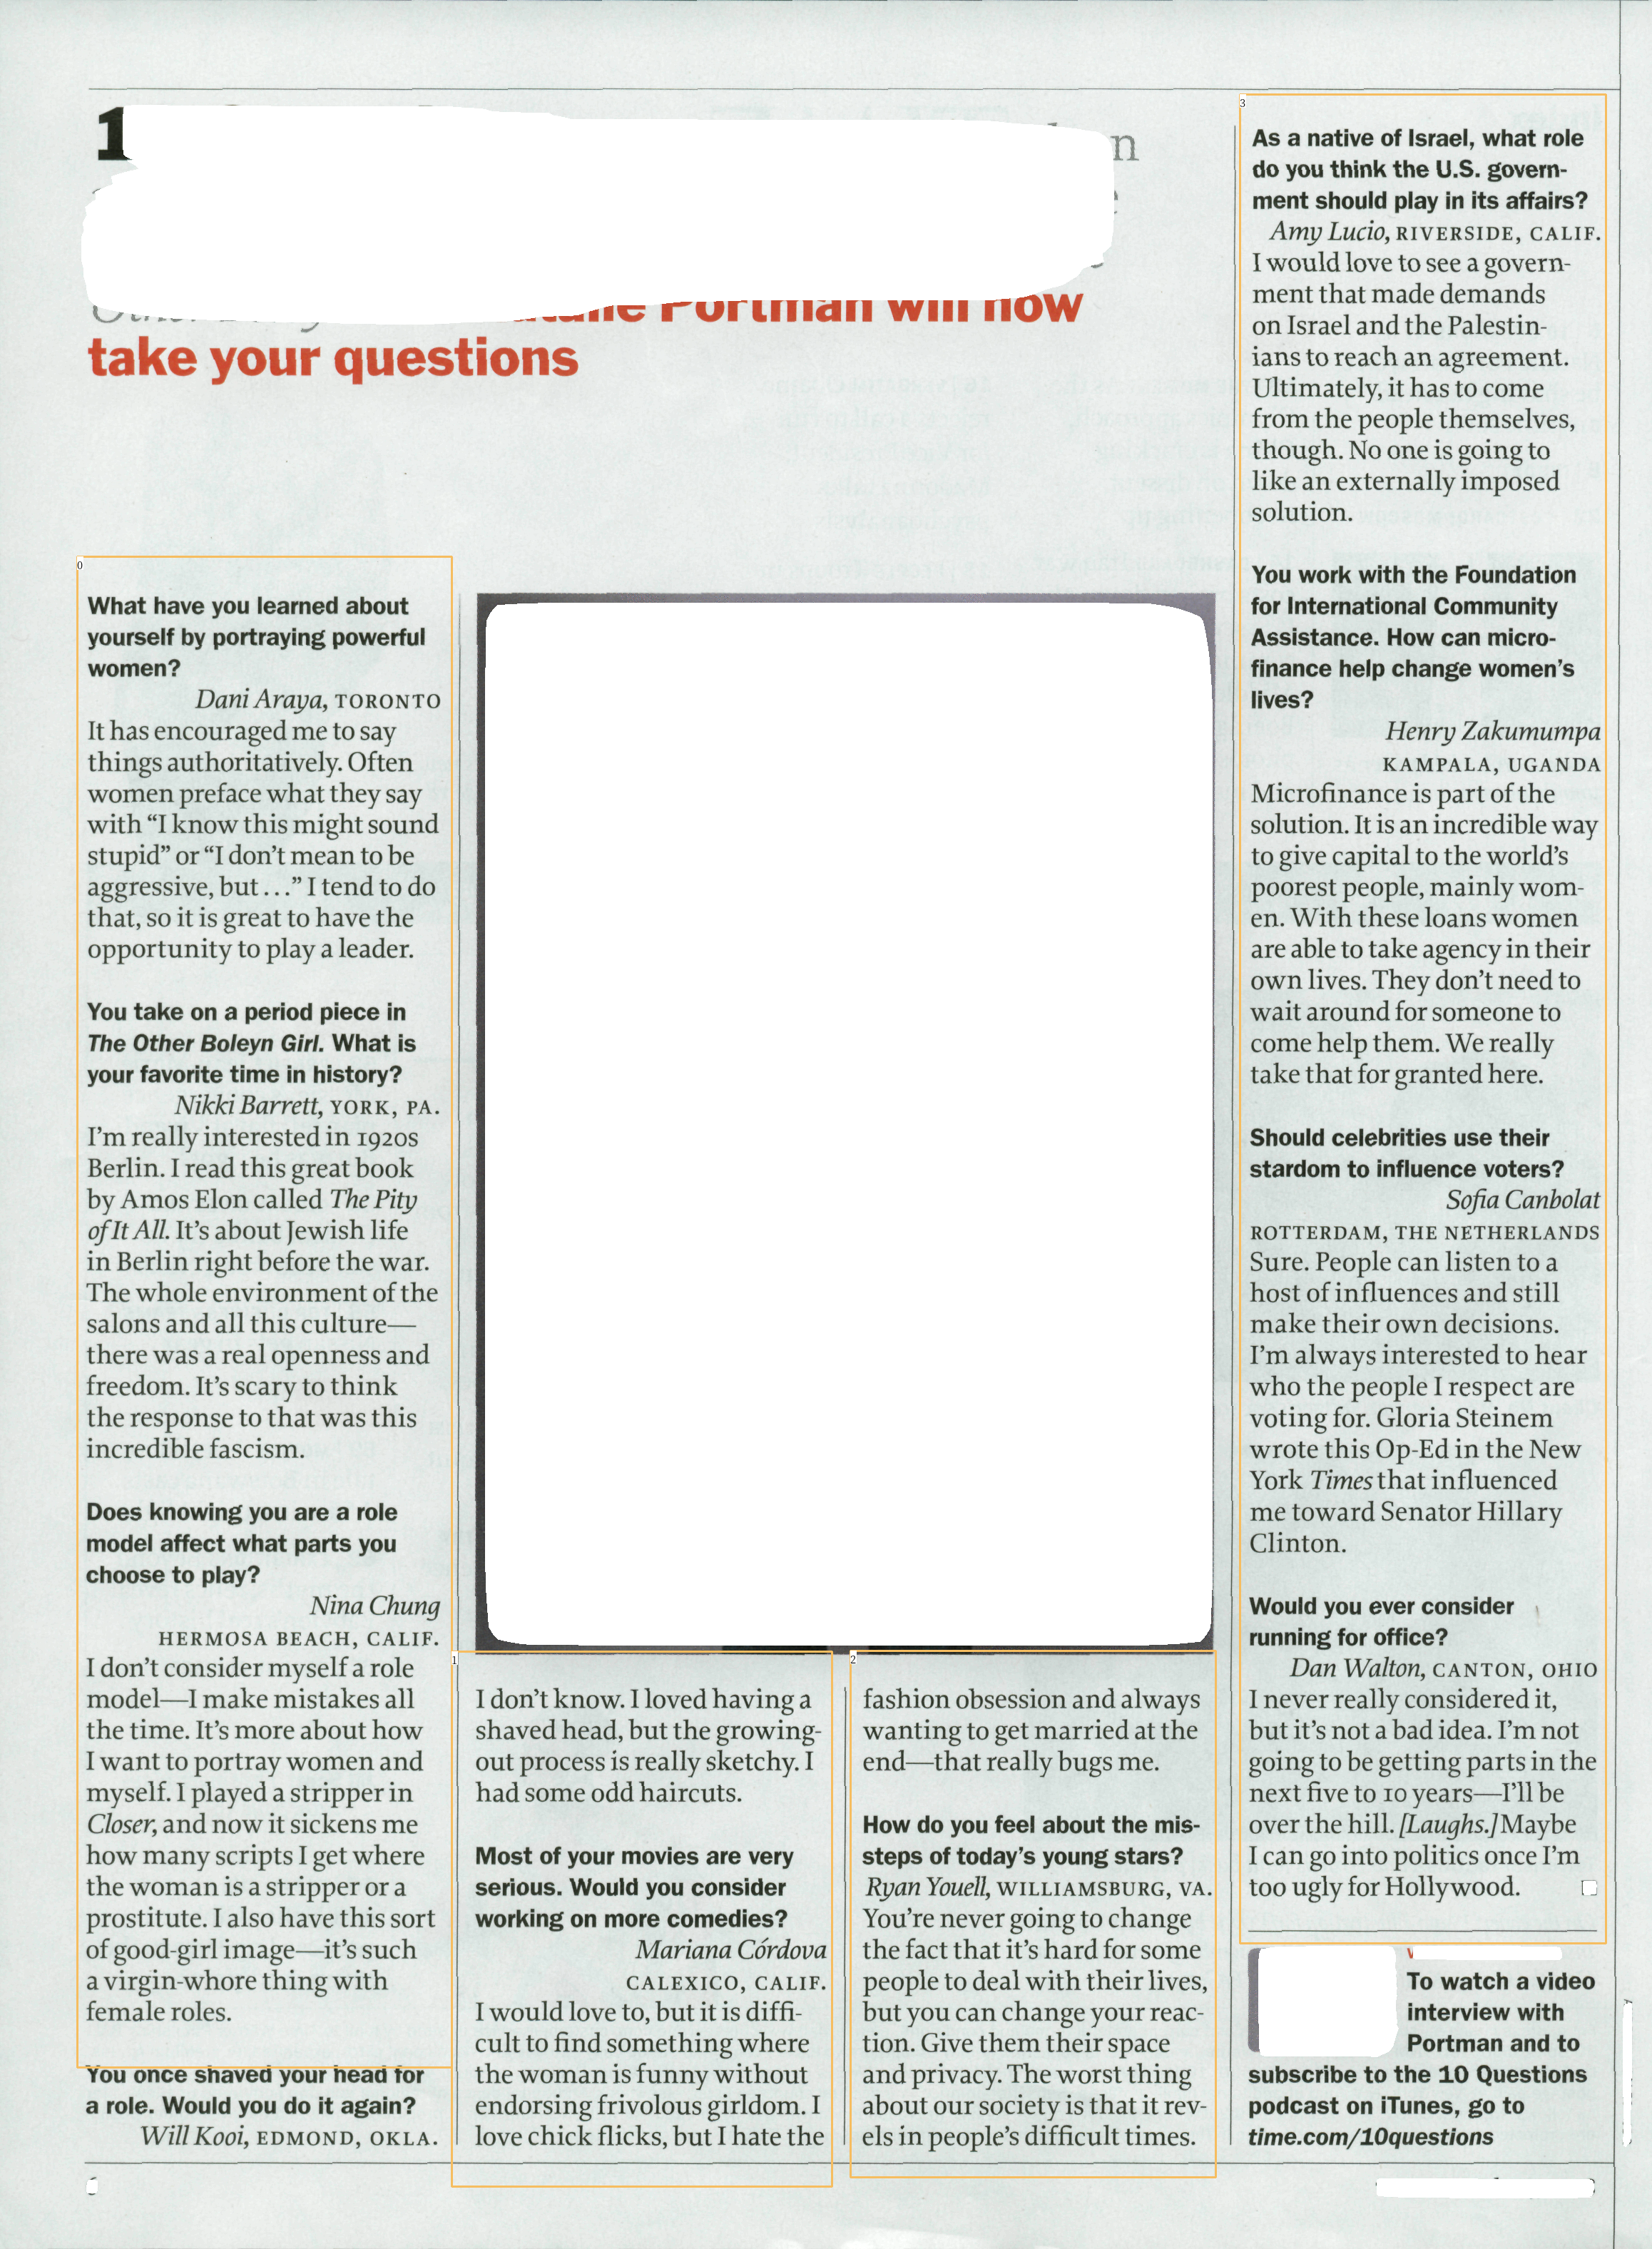

In [11]:
viz.draw_box(image, boxes,
            box_width=3, 
            show_element_id=True)

# OCR Engine
For the OCR engine Tesseract OCR is used, development of the engine has been sponsored by Google since 2006. We make API calls to the OCR for each ordered paragraph box.

In [12]:
arr_im = np.asarray(im)

for block in boxes:
    segment_image = (block.crop_image(arr_im))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)


for txt in boxes.get_texts():
    print(txt, end='\n---\n')

What have you learned about
yourself by portraying powerful
women?

Dani Araya, TORONTO
It has encouraged me to say
things authoritatively. Often
women preface what they say
with “I know this might sound
stupid” or “I don’t mean to be
aggressive, but...” I tend to do
that, so it is great to have the
opportunity to play a leader.

You take on a period piece in
The Other Boleyn Girl. What is
your favorite time in history?
Nikki Barrett, YORK, PA.
I’m really interested in 1920s
Berlin. I read this great book
by Amos Elon called The Pity
of It All. It’s about Jewish life
in Berlin right before the war.
The whole environment of the
salons and all this culture—
there was a real openness and
freedom. It’s scary to think
the response to that was this
incredible fascism.

Does knowing you are a role
model affect what parts you
choose to play?
Nina Chung

HERMOSA BEACH, CALIF.
I don’t consider myself a role
model—I make mistakes all
the time. It’s more about how
I want to portray women and
mysel